In [432]:
import sys, os, platform, glob, zipfile, math, shutil, random, gc, json, re, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quiet installs if missing
try:
    import seaborn as sns
except Exception:
    !pip -q install seaborn
    import seaborn as sns

try:
    import sklearn
except Exception:
    !pip -q install -U scikit-learn
    import sklearn

try:
    import tensorflow as tf
except Exception:
    !pip -q install -U tensorflow
    import tensorflow as tf

print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
TensorFlow: 2.19.0
GPU available: False


In [433]:
df1 = pd.read_csv('muontracks1.csv')

iD = df1['collisionID'].to_numpy()
trackID = df1['trackID'].to_numpy()
mcID = df1['mcID'].to_numpy()
eta = df1['eta'].to_numpy()
pt = df1['pt'].to_numpy()
p = df1['p'].to_numpy()
phi = df1['phi'].to_numpy()
motherPDG = df1['motherPDG'].to_numpy()
nClusters = df1['nClusters'].to_numpy()
trackType = df1['trackType'].to_numpy()
pDca = df1['pDca'].to_numpy()
chi2 = df1['chi2'].to_numpy()
chi2MatchMCHMID = df1['chi2MatchMCHMID'].to_numpy()


In [434]:
df1.head(8)


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt
0,111,0,88367,-3.16496,0.243115,2.884550,-2.590800,211,11,3,76.7159,0.515625,1.218750,1
1,111,1,88367,2.72339,0.115458,0.883115,6.495230,211,11,0,76.7159,370688.000000,1.218750,1
2,125,2,102667,-3.41393,0.858880,13.062400,2.801200,321,12,3,44.9307,0.144531,0.554688,1
3,125,3,102667,-3.43907,0.996715,15.543900,2.779760,321,12,0,44.9307,37.000000,0.554688,1
4,168,4,133004,-2.81062,0.592036,4.937700,-2.291630,211,10,2,58.2282,1000.000000,-1.000000,1
5,168,5,133004,-2.35260,0.211855,1.123670,-2.230570,211,10,4,58.2282,0.578125,-1.000000,1
6,218,6,171002,-2.93607,0.560673,5.296890,1.075610,321,10,3,140.5290,0.210938,1.062500,1
7,218,7,171002,-3.42954,0.515674,7.965860,0.911866,321,10,0,140.5290,69.000000,1.062500,1


In [435]:
#len(df1)
df1.shape

(63807, 14)

In [436]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63807 entries, 0 to 63806
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   collisionID      63807 non-null  int64  
 1   trackID          63807 non-null  int64  
 2   mcID             63807 non-null  int64  
 3   eta              63778 non-null  float64
 4   pt               63807 non-null  float64
 5   p                63807 non-null  float64
 6   phi              63807 non-null  float64
 7   motherPDG        63807 non-null  int64  
 8   nClusters        63807 non-null  int64  
 9   trackType        63807 non-null  int64  
 10  pDca             63807 non-null  float64
 11  chi2             63807 non-null  float64
 12  chi2MatchMCHMID  63807 non-null  float64
 13  isPrompt         63807 non-null  int64  
dtypes: float64(7), int64(7)
memory usage: 6.8 MB


In [437]:
sns.set_theme(style="whitegrid", palette="icefire")


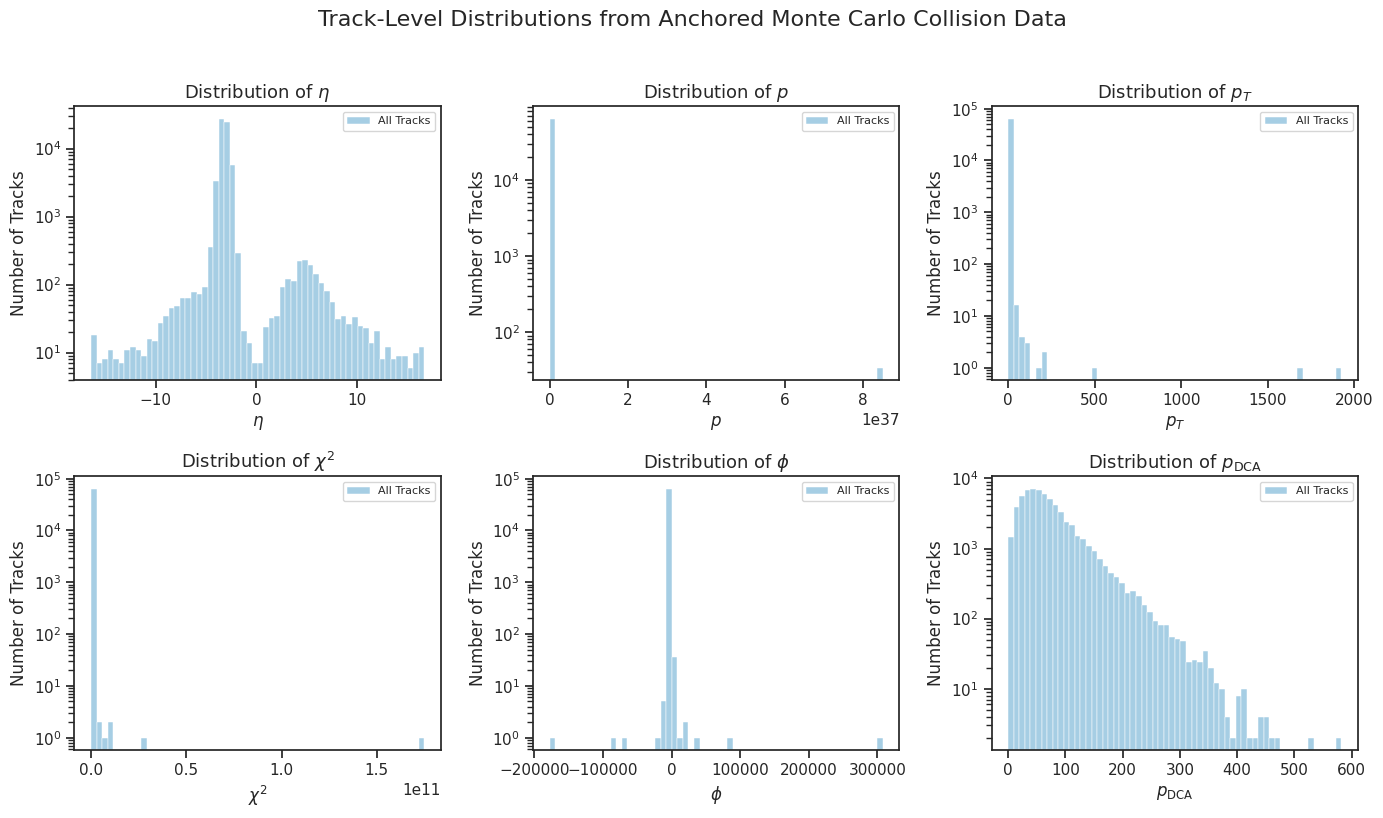

In [438]:
variables = {
    'eta': r'$\eta$',
    'p': r'$p$',
    'pt': r'$p_T$',
    'chi2': r'$\chi^2$',
    'phi': r'$\phi$',
    'pDca': r'$p_{\mathrm{DCA}}$'
}


sns.set_style("ticks")


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()


color = sns.color_palette("Blues", 6)[0]


for ax, (col, label) in zip(axes, variables.items()):
    sns.histplot(df1[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[3], label='All Tracks')
    ax.set_yscale('log')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Number of Tracks', fontsize=12)
    ax.set_title(f'Distribution of {label}', fontsize=13)
    ax.legend(fontsize=8)
    ax.grid(False)


fig.suptitle('Track-Level Distributions from Anchored Monte Carlo Collision Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [439]:
#we can add code so that when we choose B mesons as signal we remove D from background and vice versa...

# Define signal and D mesons
signalPDG = [511, 521, 531, 541]   # B mesons
dMesons   = [411, 421, 431]        # D mesons

signal = []
background = []

for val in df1['motherPDG']:
    if val in signalPDG:
        signal.append(val)
    elif val not in dMesons:  # keep only non-D backgrounds
        background.append(val)

print(len(signal))
print(len(background))

signalRows = []
backgroundRows = []

for _, row in df1.iterrows():
    if row['motherPDG'] in signalPDG:
        signalRows.append(row)
    elif row['motherPDG'] not in dMesons:
        backgroundRows.append(row)

dfSignal = pd.DataFrame(signalRows)
dfBackground = pd.DataFrame(backgroundRows)

ratioSB = len(signal)/len(background) if len(background) > 0 else float('inf')

print(np.unique(background))
print(np.unique(signal))
print(ratioSB*100)
dfSignal

520
57163
[  15  113  130  211  221  223  321  331  333  443 2212 4122 4132 4232
 5122 5132 5232]
[511 521 531 541]
0.9096793380333432


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt
340,1131.0,42.0,901445.0,-2.92081,3.094240,28.79230,2.580150,511.0,11.0,3.0,33.25290,5.737300e-02,0.625000,1.0
341,1131.0,43.0,901445.0,-2.92202,3.413690,31.80290,2.574860,511.0,11.0,0.0,33.25290,9.750000e+00,0.625000,1.0
906,442.0,14.0,355004.0,-2.90731,0.939557,8.62616,-1.999950,521.0,10.0,3.0,113.62700,1.103520e-01,0.355469,1.0
907,442.0,15.0,355004.0,-3.15249,0.949027,11.12120,-1.764280,521.0,10.0,0.0,113.62700,1.912500e+01,0.355469,1.0
958,950.0,28.0,750792.0,-3.36680,1.372540,19.91570,2.144440,511.0,10.0,3.0,372.71500,4.956050e-02,1.210940,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63011,527.0,82.0,926931.0,-2.97527,0.244275,2.39951,-2.410980,521.0,10.0,0.0,85.09310,2.719740e+06,0.318359,1.0
63611,518.0,62.0,982465.0,-4.00165,1.435680,39.27050,-1.617540,521.0,10.0,2.0,3.15337,2.380800e+04,-1.000000,1.0
63612,518.0,63.0,982465.0,-3.83550,1.425810,33.03470,-0.872725,521.0,10.0,4.0,3.15337,5.688480e-02,-1.000000,1.0
63652,595.0,53.0,1062650.0,-2.88872,0.884379,7.97084,1.783430,521.0,10.0,3.0,134.23000,4.062500e-01,2.640620,1.0


In [440]:
df1_filtered = df1[(df1['chi2'] <=2) & (df1['eta'] >= -4) & (df1['eta']<=-2.5) & (df1['trackType'] == 3) & (df1['p']>4) ].copy()#& (df1['p']>4)

iD = df1_filtered['collisionID'].to_numpy()
trackID = df1_filtered['trackID'].to_numpy()
mcID = df1_filtered['mcID'].to_numpy()
eta = df1_filtered['eta'].to_numpy()
pt = df1_filtered['pt'].to_numpy()
p = df1_filtered['p'].to_numpy()
phi = df1_filtered['phi'].to_numpy()
motherPDG = df1_filtered['motherPDG'].to_numpy()
nClusters = df1_filtered['nClusters'].to_numpy()
trackType = df1_filtered['trackType'].to_numpy()
pDca = df1_filtered['pDca'].to_numpy()
chi2 = df1_filtered['chi2'].to_numpy()
chi2MatchMCHMID = df1_filtered['chi2MatchMCHMID'].to_numpy()

In [441]:
df1_filtered.shape

(13200, 14)

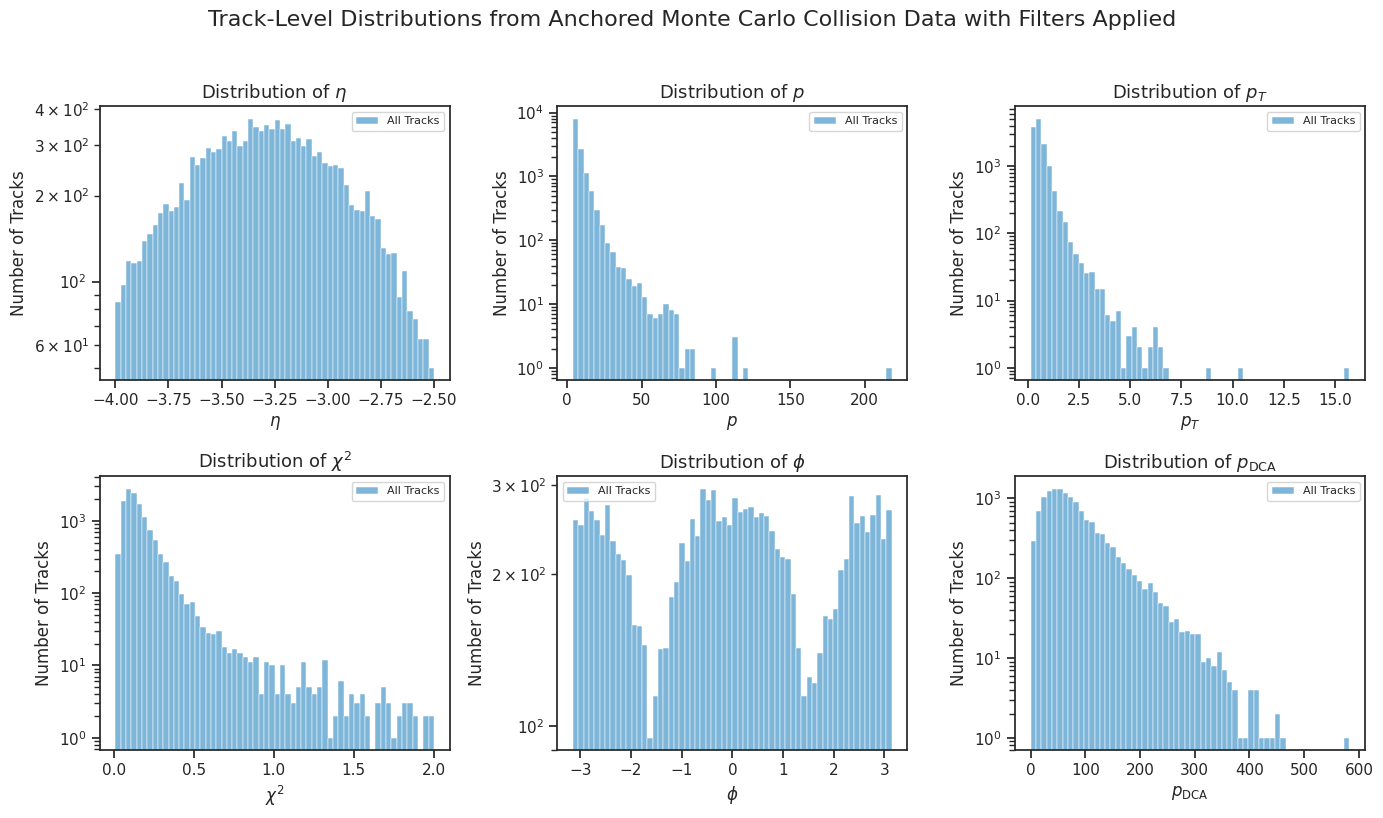

In [442]:
variables = {
    'eta': r'$\eta$',
    'p': r'$p$',
    'pt': r'$p_T$',
    'chi2': r'$\chi^2$',
    'phi': r'$\phi$',
    'pDca': r'$p_{\mathrm{DCA}}$'
}


sns.set_style("ticks")


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()


color = sns.color_palette("Blues", 6)[0]


for ax, (col, label) in zip(axes, variables.items()):
    sns.histplot(df1_filtered[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[2], label='All Tracks')
    ax.set_yscale('log')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Number of Tracks', fontsize=12)
    ax.set_title(f'Distribution of {label}', fontsize=13)
    ax.legend(fontsize=8)
    ax.grid(False)


fig.suptitle('Track-Level Distributions from Anchored Monte Carlo Collision Data with Filters Applied', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


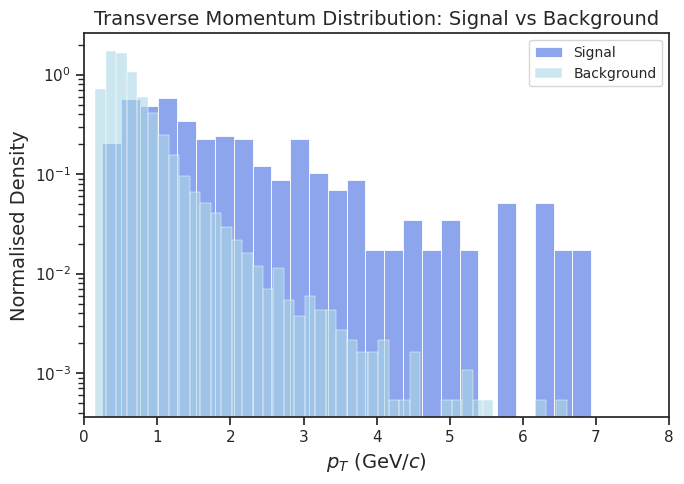

In [443]:
signalPDG = [511, 521, 531, 541]

is_signal = df1_filtered['motherPDG'].isin(signalPDG)
is_background = ~is_signal

pt_signal = df1_filtered.loc[is_signal, 'pt']
pt_background = df1_filtered.loc[is_background, 'pt']

sns.set_style("ticks")
plt.figure(figsize=(7,5))
sns.histplot(pt_signal, bins=60, color='royalblue', label='Signal', stat='density', alpha=0.6)
sns.histplot(pt_background, bins=60, color='lightblue', label='Background', stat='density', alpha=0.6)

plt.yscale('log')
plt.xlabel(r'$p_T$ (GeV/$c$)', fontsize=14)
plt.xlim(0,8)
plt.ylabel('Normalised Density', fontsize=14)
plt.title('Transverse Momentum Distribution: Signal vs Background', fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()


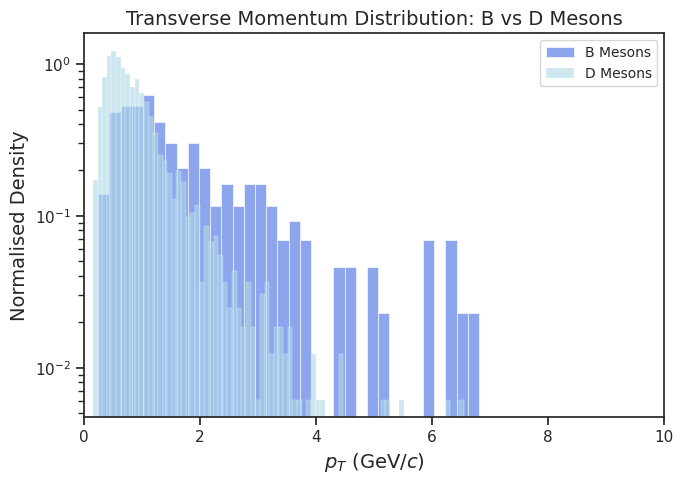

In [444]:
B = [511, 521, 531, 541]   # B mesons
D = [411, 421, 431]

df1_filtered['motherPDG'] = pd.to_numeric(df1_filtered['motherPDG'], errors='coerce')

mask_B = df1_filtered['motherPDG'].isin(B)
mask_D = df1_filtered['motherPDG'].isin(D)

pt_B = df1_filtered.loc[mask_B, 'pt'].dropna()
pt_D = df1_filtered.loc[mask_D, 'pt'].dropna()


plt.figure(figsize=(7,5))
sns.histplot(pt_B, bins=80, color='royalblue', label='B Mesons', stat='density', alpha=0.6)
sns.histplot(pt_D, bins=80, color='lightblue', label='D Mesons', stat='density', alpha=0.6)

plt.yscale('log')
plt.xlabel(r'$p_T$ (GeV/$c$)', fontsize=14)
plt.xlim(0,10)
plt.ylabel('Normalised Density', fontsize=14)
plt.title('Transverse Momentum Distribution: B vs D Mesons', fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()


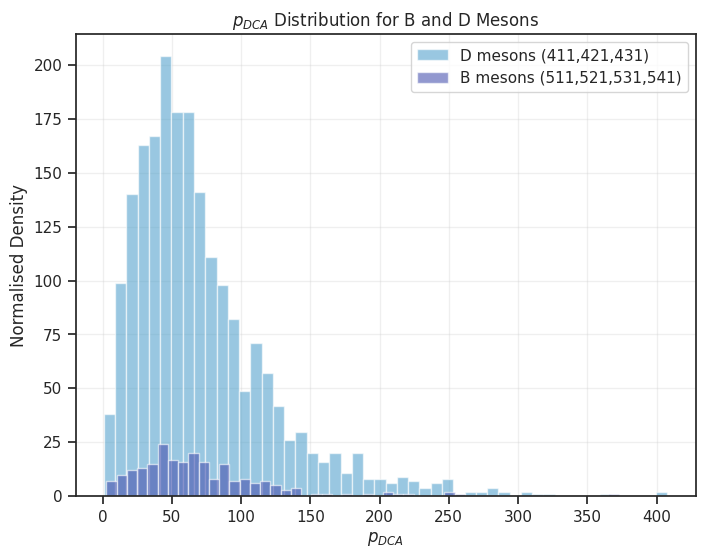

In [445]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons


df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
plt.hist(df_D['pDca'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['pDca'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$p_{DCA}$')
plt.ylabel("Normalised Density")
plt.title(r"$p_{DCA}$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [446]:
#we can add code so that when we choose B mesons as signal we remove D from background and vice versa...
print(np.unique(df1_filtered['motherPDG']))
# Define signal and D mesons
bMesons = [511, 521, 531, 541]   # B mesons
dMesons   = [411, 421, 431]        # D mesons

signal = []
background = []

for val in df1_filtered['motherPDG']:
    if val in bMesons:
        signal.append(val)
    elif val not in dMesons:  # keep only non-D backgrounds
        background.append(val)

print(len(signal))
print(len(background))

signalRows = []
backgroundRows = []

for _, row in df1_filtered.iterrows():
    if row['motherPDG'] in bMesons:
        signalRows.append(row)
    elif row['motherPDG'] not in dMesons:
        backgroundRows.append(row)

dfSignal = pd.DataFrame(signalRows)
dfBackground = pd.DataFrame(backgroundRows)

ratioSB = len(signal)/len(background) if len(background) > 0 else float('inf')

print(np.unique(background))
print(np.unique(signal))
print(ratioSB*100)
dfSignal

[  15  113  130  211  221  223  321  331  333  411  421  431  443  511
  521  531 2212 4122 4132 4232 5122 5232]
225
10941
[  15  113  130  211  221  223  321  331  333  443 2212 4122 4132 4232
 5122 5232]
[511 521 531]
2.056484782012613


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt
340,1131.0,42.0,901445.0,-2.92081,3.094240,28.79230,2.580150,511.0,11.0,3.0,33.2529,0.057373,0.625000,1.0
906,442.0,14.0,355004.0,-2.90731,0.939557,8.62616,-1.999950,521.0,10.0,3.0,113.6270,0.110352,0.355469,1.0
958,950.0,28.0,750792.0,-3.36680,1.372540,19.91570,2.144440,511.0,10.0,3.0,372.7150,0.049561,1.210940,1.0
1082,706.0,44.0,585562.0,-3.49920,1.023230,16.94420,0.277457,521.0,10.0,3.0,190.7930,0.101074,0.156250,1.0
1310,318.0,10.0,242865.0,-3.28401,1.016000,13.57380,1.118810,521.0,10.0,3.0,32.9962,0.061523,1.210940,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62231,347.0,32.0,559773.0,-2.68759,1.171790,8.65033,-0.803449,511.0,10.0,3.0,64.8344,0.088867,0.074219,1.0
62411,335.0,48.0,1003528.0,-3.01823,1.382730,14.17580,-1.087260,511.0,13.0,3.0,33.2265,0.048096,0.710938,1.0
62479,521.0,68.0,979741.0,-2.94525,1.372540,13.08580,-0.772655,521.0,10.0,3.0,136.2690,0.056397,1.625000,1.0
62945,408.0,52.0,743969.0,-2.59741,2.843460,19.19820,-3.030970,521.0,9.0,3.0,73.6387,0.033936,0.314453,1.0


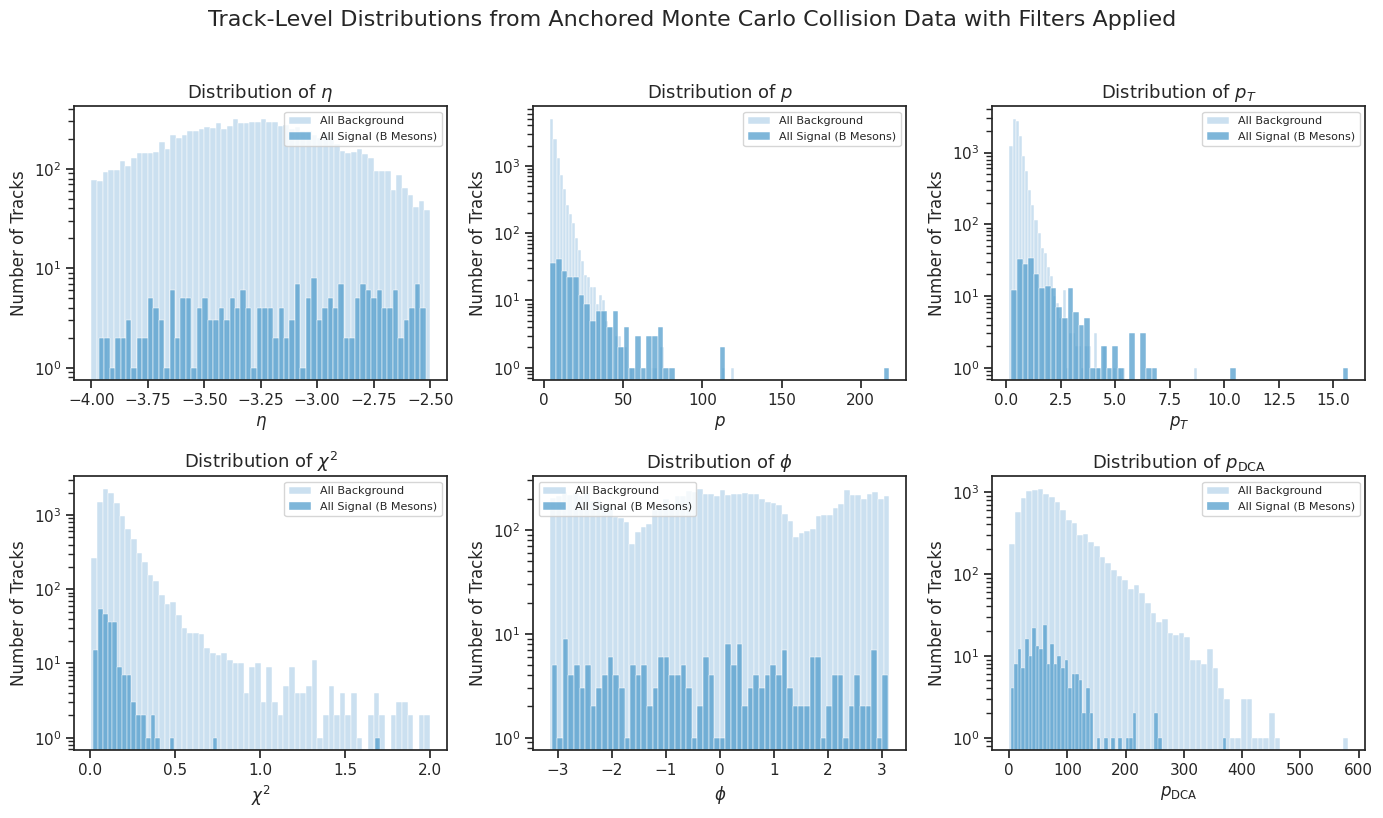

In [447]:
variables = {
    'eta': r'$\eta$',
    'p': r'$p$',
    'pt': r'$p_T$',
    'chi2': r'$\chi^2$',
    'phi': r'$\phi$',
    'pDca': r'$p_{\mathrm{DCA}}$'
}


sns.set_style("ticks")


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()


color = sns.color_palette("Blues", 6)[0]


for ax, (col, label) in zip(axes, variables.items()):
    sns.histplot(dfBackground[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[4], label='All Background')
    sns.histplot(dfSignal[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[2], label='All Signal (B Mesons)')
    ax.set_yscale('log')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Number of Tracks', fontsize=12)
    ax.set_title(f'Distribution of {label}', fontsize=13)
    ax.legend(fontsize=8)
    ax.grid(False)


fig.suptitle('Track-Level Distributions from Anchored Monte Carlo Collision Data with Filters Applied', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [448]:
#Add a label column to set to identify signal particles with a value s and background particles with a value b

label = []
#iterrows() -> used to iterate over the rows of a DataFrame. It returns a generator that yields pairs of (index, Series) for each row.
for index, row in df1_filtered.iterrows():
  if row['motherPDG'] in bMesons:
    label.append('s')
  else:
    label.append('b')

df1_filtered['label'] = label

df1_filtered
print(df1_filtered.info())


<class 'pandas.core.frame.DataFrame'>
Index: 13200 entries, 2 to 63805
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   collisionID      13200 non-null  int64  
 1   trackID          13200 non-null  int64  
 2   mcID             13200 non-null  int64  
 3   eta              13200 non-null  float64
 4   pt               13200 non-null  float64
 5   p                13200 non-null  float64
 6   phi              13200 non-null  float64
 7   motherPDG        13200 non-null  int64  
 8   nClusters        13200 non-null  int64  
 9   trackType        13200 non-null  int64  
 10  pDca             13200 non-null  float64
 11  chi2             13200 non-null  float64
 12  chi2MatchMCHMID  13200 non-null  float64
 13  isPrompt         13200 non-null  int64  
 14  label            13200 non-null  object 
dtypes: float64(7), int64(7), object(1)
memory usage: 1.6+ MB
None


In [449]:

#Adding a new col y here (realted to label) - if label is s then y col gets a 1
#.astype(int)- is used to convert the data type of a Series, DataFrame column, or NumPy array to an integer type.
df1_filtered["y"] = (df1_filtered["label"] == "s").astype(int)


In [450]:
# from sklearn.model_selection import train_test_split
# #stratify = df1_filtered['motherPDG']
# training_df, testing_df = train_test_split(df1_filtered, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split
#Ensure sets are mutually exclusive:
# Step 1: Get unique collisionIDs
unique_ids = df1_filtered["collisionID"].unique()

# Step 2: Split those IDs
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=0)

# Step 3: Create training and testing sets based on those IDs
training_df = df1_filtered[df1_filtered["collisionID"].isin(train_ids)]
testing_df = df1_filtered[df1_filtered["collisionID"].isin(test_ids)]

In [451]:
shared_collisionIDs = np.intersect1d(training_df["collisionID"].unique(), testing_df["collisionID"].unique())
shared_trackIDs = np.intersect1d(training_df["trackID"].unique(), testing_df["trackID"].unique())

print("Shared collisionIDs:", len(shared_collisionIDs))
print("Shared trackIDs:", len(shared_trackIDs))

Shared collisionIDs: 0
Shared trackIDs: 103


In [452]:
# Calculate the signal/background ratio in the training set
training_signal_count = training_df[training_df['motherPDG'].isin(bMesons)].shape[0]
training_background_count = training_df[~training_df['motherPDG'].isin(bMesons)].shape[0]
training_ratio_SB = training_signal_count / training_background_count if training_background_count > 0 else 0
print(f"Training set Signal/Background Ratio: {training_ratio_SB*100:.2f}%")

# Calculat the signal/background ratio in the testing set
testing_signal_count = testing_df[testing_df['motherPDG'].isin(bMesons)].shape[0]
testing_background_count = testing_df[~testing_df['motherPDG'].isin(bMesons)].shape[0]
testing_ratio_SB = testing_signal_count / testing_background_count if testing_background_count > 0 else 0
print(f"Testing set Signal/Background Ratio: {testing_ratio_SB*100:.2f}%")

# Calculat the signal/background ratio in the original filtered data
original_signal_count = df1_filtered[df1_filtered['motherPDG'].isin(bMesons)].shape[0]
original_background_count = df1_filtered[~df1_filtered['motherPDG'].isin(bMesons)].shape[0]
original_ratio_SB = original_signal_count / original_background_count if original_background_count > 0 else 0
print(f"Original filtered data Signal/Background Ratio: {original_ratio_SB*100:.2f}%")


Training set Signal/Background Ratio: 1.80%
Testing set Signal/Background Ratio: 1.49%
Original filtered data Signal/Background Ratio: 1.73%


In [453]:
from sklearn.utils.class_weight import compute_class_weight
 #This function calculates weights for each class in a classification problem to help balance datasets that are imbalanced
 #(i.e., some classes appear more often than others).

 #np.unique(...) finds all unique class labels in y.
classes = np.unique(training_df["y"])

#class_weight="balanced": automatically adjusts the weights inversely proportional to class frequencies, so rare classes get higher weight.
#classes=classes: the list of all unique classes.
#y=training_df["y"]: the array of actual class labels.

class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=training_df["y"])

#zip(classes, class_weights) pairs each class with its corresponding weight.
#dict(...) converts these pairs into a dictionary.
#Result: class_weights_dict might look like {0: 2.0, 1: 0.67}.
class_weights_dict = dict(zip(classes, class_weights))

print("Class weight Background:", class_weights_dict[0])
print("Class weight Signal:", class_weights_dict[1])
training_df = training_df.copy()
training_df['w'] = training_df['y'].map(class_weights_dict)

training_df.head(8)

Class weight Background: 0.5089928057553957
Class weight Signal: 28.3


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt,label,y,w
2,125,2,102667,-3.41393,0.858880,13.06240,2.801200,321,12,3,44.9307,0.144531,0.554688,1,b,0,0.508993
6,218,6,171002,-2.93607,0.560673,5.29689,1.075610,321,10,3,140.5290,0.210938,1.062500,1,b,0,0.508993
8,252,10,197209,-3.73895,0.510914,10.74910,0.096842,321,10,3,51.1675,0.232422,1.304690,1,b,0,0.508993
10,354,12,270373,-3.27961,0.391250,5.20425,-2.726100,431,10,3,117.9410,0.251953,0.621094,1,b,0,0.508993
20,719,22,540836,-3.46161,0.574716,9.16664,-0.345634,321,12,3,134.2360,0.092773,0.703125,1,b,0,0.508993
34,877,38,657418,-2.95560,0.560175,5.39596,2.508450,211,10,3,105.3500,0.173828,1.203120,0,b,0,0.508993
40,1048,44,794431,-3.42910,0.450159,6.95075,-0.699739,211,9,3,72.4956,0.253906,0.349609,1,b,0,0.508993
48,1234,52,929289,-3.73591,0.212669,4.46073,-2.836690,211,10,3,128.8290,0.185547,1.765620,1,b,0,0.508993


In [454]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


FEATURE_EXCLUDE = ["collisionID","trackID","mcID","motherPDG","trackType","nClusters","chi2MatchMCHMID", "isPrompt", "label" ,"w", "y"]
features = [c for c in training_df.columns if c not in FEATURE_EXCLUDE]


X_raw = training_df[features].copy()
y = training_df["y"].values
w = training_df["w"].values

X_test_raw = testing_df[features].copy()
y_test = testing_df["y"].values


X_train_raw, X_val_train, y_train, y_val,w_train, w_val = train_test_split(X_raw, y, w, test_size=0.2, random_state=42, stratify=y)

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train_raw)
X_val_imputed = imputer.transform(X_val_train)
X_test_imputed = imputer.transform(X_test_raw)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train = X_train_scaled
X_test = X_test_scaled
X_val = X_val_scaled

print("Num features:", len(features))
print(features)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)



Num features: 6
['eta', 'pt', 'p', 'phi', 'pDca', 'chi2']
(8376, 6)
(2095, 6)
(2729, 6)


In [455]:
import numpy as np


unique, counts = np.unique(y_train, return_counts=True)
counts_dict = dict(zip(unique, counts))
print("Counts Background:", counts_dict[0])
print("Counts Signal:", counts_dict[1])

signal = counts_dict.get(1, 0)
background = counts_dict.get(0, 0)
ratio = signal / background
print(f"Signal:Background = {signal}:{background} ≈ {ratio:.3f}")

Counts Background: 8228
Counts Signal: 148
Signal:Background = 148:8228 ≈ 0.018


In [456]:
from sklearn.linear_model import LogisticRegression #LogisticRegression: a linear classification model for binary or multi-class problems.
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve

logit = LogisticRegression(max_iter=5000)  # robust default solver

logit.fit(X_train, y_train, sample_weight=w_train)

proba_val_lr = logit.predict_proba(X_val)[:,1]



pred_val_lr = (proba_val_lr >= 0.65).astype(int)


metrics_lr = {
    "Accuracy": accuracy_score(y_val, pred_val_lr, sample_weight=w_val),
    "F1": f1_score(y_val, pred_val_lr, sample_weight=w_val),#Harmonic mean of precision (how many predicted positives are correct) and recall (how many actual positives are detected).Good value: closer to 1 is better.
    "ROC_AUC": roc_auc_score(y_val, proba_val_lr, sample_weight=w_val),#Measures the model’s ability to distinguish between classes at all possible thresholds.0.8–0.9 → good
    "ConfusionMatrix": confusion_matrix(y_val, pred_val_lr, sample_weight=w_val)
}
metrics_lr



{'Accuracy': 0.7355657076205288,
 'F1': 0.6714570376185022,
 'ROC_AUC': np.float64(0.8590864917395526),
 'ConfusionMatrix': array([[974.72122302,  72.78597122],
        [481.1       , 566.        ]])}

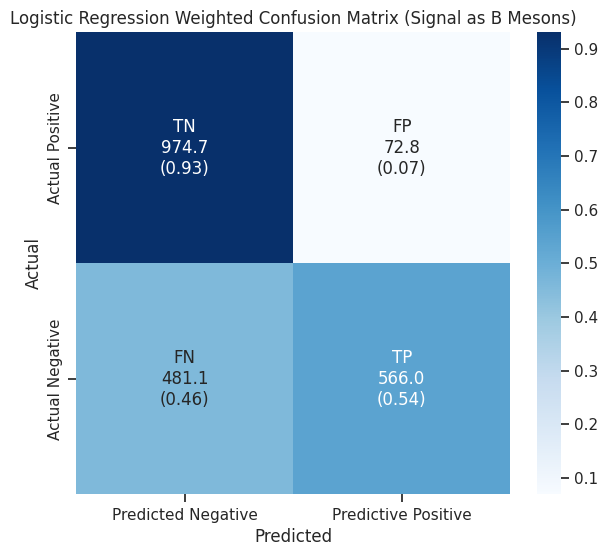

In [457]:
cm = metrics_lr["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Blues",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Weighted Confusion Matrix (Signal as B Mesons)")
plt.show()

/tmp/ipython-input-3184272870.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)


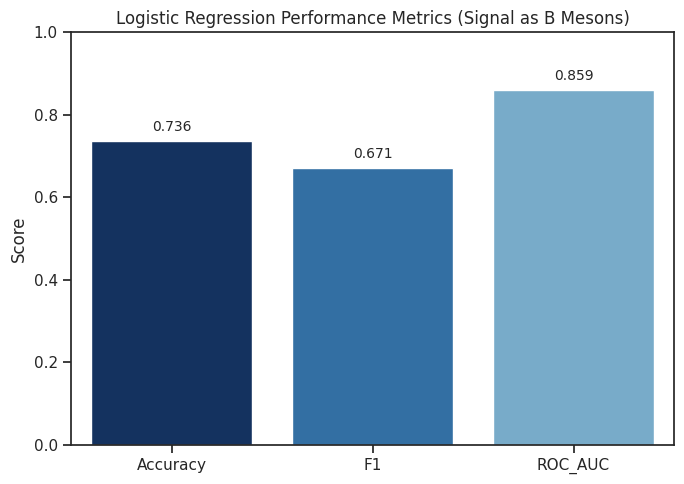

In [458]:
scalar_metrics = {k: v for k, v in metrics_lr.items() if k != "ConfusionMatrix"}
metrics_names = list(scalar_metrics.keys())
metrics_values = list(scalar_metrics.values())

palette = ["#08306b", "#2171b5", "#6baed6"]

plt.figure(figsize=(7,5))
bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)

for bar, value in zip(bars.patches, metrics_values):
    height = bar.get_height()
    bars.annotate(f"{value:.3f}",
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=10)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Logistic Regression Performance Metrics (Signal as B Mesons)")
plt.tight_layout()
plt.show()



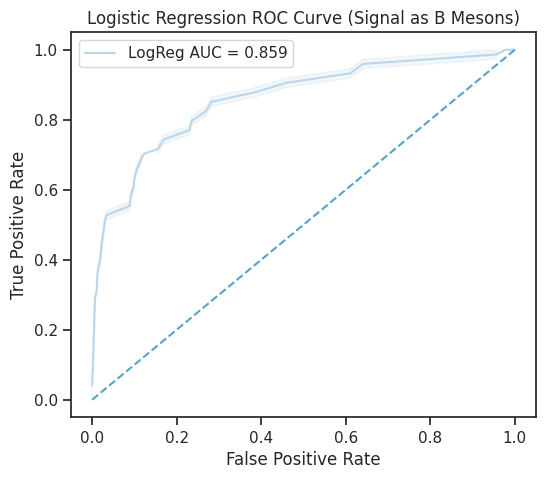

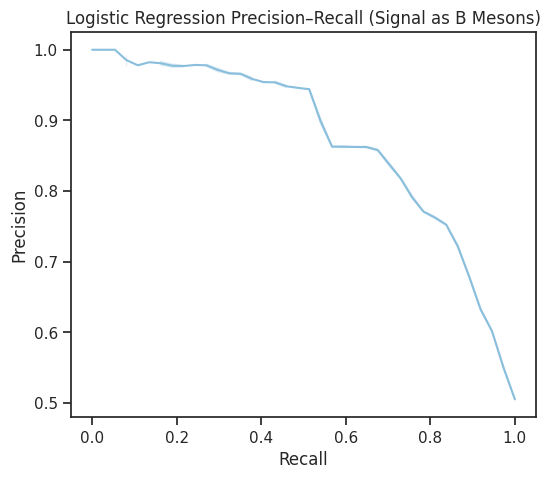

Weighted confusion matrix (threshold=0.45):
 [[974.72122302  72.78597122]
 [481.1        566.        ]]


In [459]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, proba_val_lr, sample_weight=w_val)

plt.figure(figsize=(6,5))
sns.lineplot(x=fpr, y=tpr, color = sns.color_palette("Blues_r")[4], label=f"LogReg AUC = {roc_auc_score(y_val, proba_val_lr, sample_weight=w_val):.3f}")
plt.plot([0,1],[0,1],'--') #Plots a diagonal dashed line representing a random classifier baseline.
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve (Signal as B Mesons)");
plt.grid(False)
plt.legend();
plt.show()

# Precision–Recall
prec, rec, thr = precision_recall_curve(y_val, proba_val_lr, sample_weight=w_val)
plt.figure(figsize=(6,5))
sns.lineplot(x=rec, y=prec, color = sns.color_palette("Blues")[2])
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.grid(False)
plt.title("Logistic Regression Precision–Recall (Signal as B Mesons)");
plt.show()

print("Weighted confusion matrix (threshold=0.45):\n", metrics_lr["ConfusionMatrix"])

  Feature  Coefficient
1      pt     0.882859
2       p     0.400807
0     eta     0.395424
5    chi2    -0.176690
3     phi    -0.217454
4    pDca    -0.295841


/tmp/ipython-input-2444859740.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='crest')


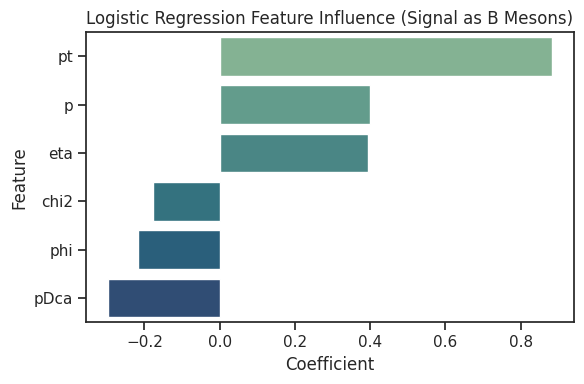

In [460]:

feature_names = ['eta', 'pt', 'p', 'phi', 'pDca', 'chi2']

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)



plt.figure(figsize=(6,4))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='crest')
plt.title('Logistic Regression Feature Influence (Signal as B Mesons)')
plt.tight_layout()
plt.show()


  Feature  Abs_Coefficient
1      pt         0.882859
2       p         0.400807
0     eta         0.395424
4    pDca         0.295841
3     phi         0.217454
5    chi2         0.176690


/tmp/ipython-input-1579188009.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_abs, x='Abs_Coefficient', y='Feature', palette='crest')


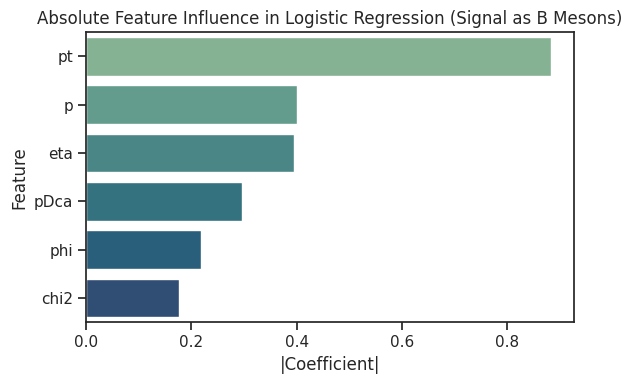

In [461]:
feature_names = ['eta', 'pt', 'p', 'phi', 'pDca', 'chi2']

feature_importance_abs = pd.DataFrame({
    'Feature': feature_names,
    'Abs_Coefficient': np.abs(logit.coef_[0])
}).sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance_abs)


plt.figure(figsize=(6,4))
sns.barplot(data=feature_importance_abs, x='Abs_Coefficient', y='Feature', palette='crest')
plt.title('Absolute Feature Influence in Logistic Regression (Signal as B Mesons)')
plt.xlabel('|Coefficient|')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [462]:
logitTest = LogisticRegression(max_iter=5000)  # robust default solver

logitTest.fit(X_test, y_test)

proba_val_lrTest = logitTest.predict_proba(X_test)[:,1]


pred_val_lrTest = (proba_val_lrTest >= 0.45).astype(int)


metrics_lrTest = {
    "Accuracy": accuracy_score(y_test, pred_val_lrTest),
    "F1": f1_score(y_test, pred_val_lrTest),#Harmonic mean of precision (how many predicted positives are correct) and recall (how many actual positives are detected).Good value: closer to 1 is better.
    "ROC_AUC": roc_auc_score(y_test, proba_val_lrTest),#Measures the model’s ability to distinguish between classes at all possible thresholds.0.8–0.9 → good
    "ConfusionMatrix": confusion_matrix(y_test, pred_val_lrTest)
}
metrics_lrTest


{'Accuracy': 0.9846097471601319,
 'F1': 0.08695652173913043,
 'ROC_AUC': np.float64(0.8473131275567126),
 'ConfusionMatrix': array([[2685,    4],
        [  38,    2]])}

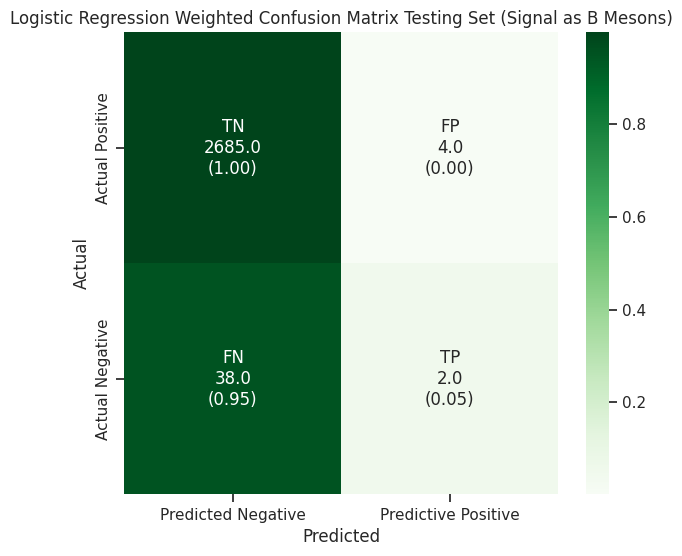

In [463]:
cm = metrics_lrTest["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Greens",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Weighted Confusion Matrix Testing Set (Signal as B Mesons)")
plt.show()

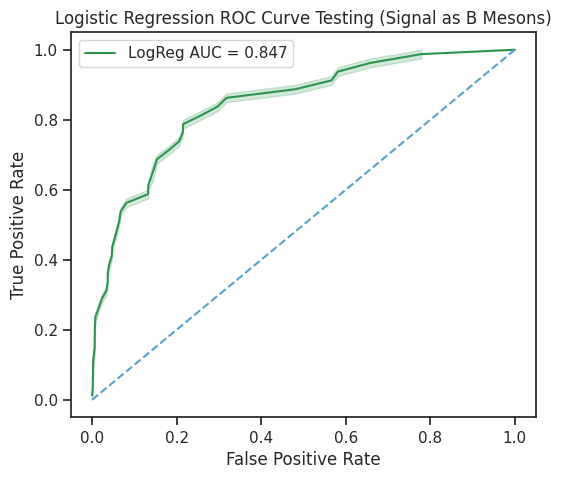

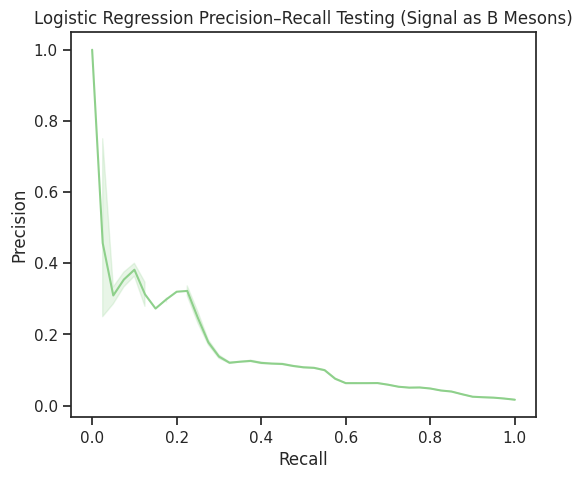

Weighted confusion matrix (threshold=0.45):
 [[974.72122302  72.78597122]
 [481.1        566.        ]]


In [464]:
# ROC Curve
fprTest, tprTest, thresholdsTest = roc_curve(y_test, proba_val_lrTest)

plt.figure(figsize=(6,5))
sns.lineplot(x=fprTest, y=tprTest, color = sns.color_palette("Greens")[4], label=f"LogReg AUC = {roc_auc_score(y_test, proba_val_lrTest):.3f}")
plt.plot([0,1],[0,1],'--') #Plots a diagonal dashed line representing a random classifier baseline.
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve Testing (Signal as B Mesons)");
plt.grid(False)
plt.legend();
plt.show()

# Precision–Recall
precTest, recTest, thrTest = precision_recall_curve(y_test, proba_val_lrTest)
plt.figure(figsize=(6,5))
sns.lineplot(x=recTest, y=precTest, color = sns.color_palette("Greens")[2])
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.grid(False)
plt.title("Logistic Regression Precision–Recall Testing (Signal as B Mesons)");
plt.show()

print("Weighted confusion matrix (threshold=0.45):\n", metrics_lr["ConfusionMatrix"])

/tmp/ipython-input-1661375235.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)


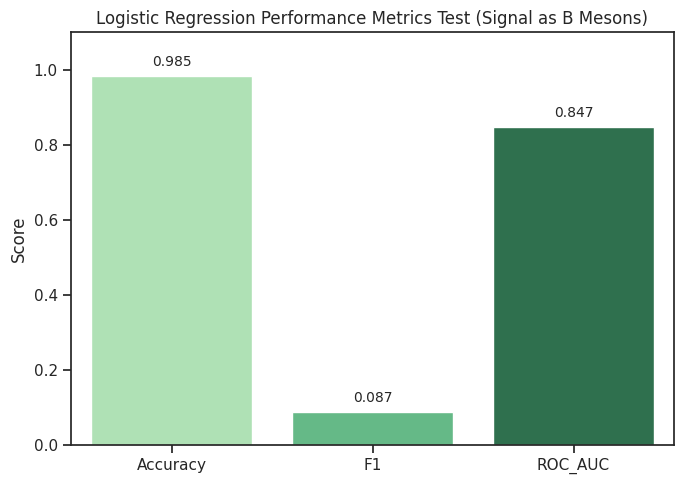

In [465]:
scalar_metricsTest = {k: v for k, v in metrics_lrTest.items() if k != "ConfusionMatrix"}
metrics_namesTest = list(scalar_metricsTest.keys())
metrics_valuesTest = list(scalar_metricsTest.values())

green_palette = ["#A7E9AF", "#57C785", "#247B4D"]
plt.figure(figsize=(7,5))
barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)

for bar, value in zip(barsTest.patches, metrics_valuesTest):
    height = bar.get_height()
    barsTest.annotate(f"{value:.3f}",
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=10)

plt.ylim(0,1.1)
plt.ylabel("Score")
plt.title("Logistic Regression Performance Metrics Test (Signal as B Mesons)")
plt.tight_layout()
plt.show()



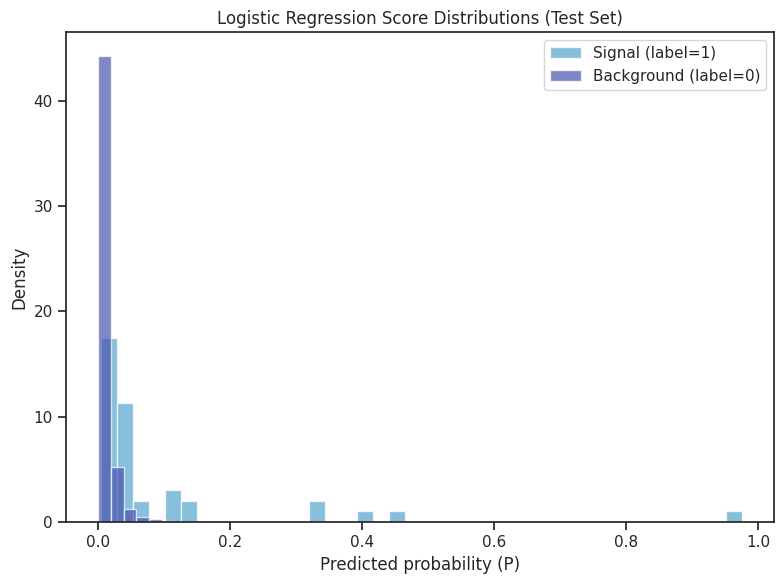

In [466]:
signal_scores = proba_val_lrTest[y_test == 1]
background_scores = proba_val_lrTest[y_test == 0]


plt.figure(figsize=(8,6))
plt.hist(signal_scores, bins=40, density=True, alpha=0.7, label='Signal (label=1)')
plt.hist(background_scores, bins=40, density=True, alpha=0.7, label='Background (label=0)')

plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Logistic Regression Score Distributions (Test Set)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

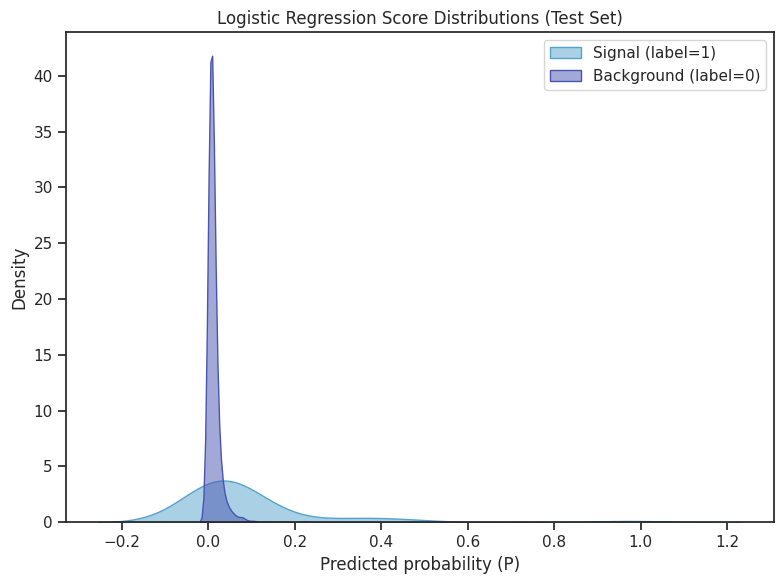

In [467]:
plt.figure(figsize=(8,6))
sns.kdeplot(signal_scores, label='Signal (label=1)', fill=True, alpha=0.5)
sns.kdeplot(background_scores, label='Background (label=0)', fill=True, alpha=0.5)
plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Logistic Regression Score Distributions (Test Set)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [506]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# Clears any previously built models/graphs from memory
# (good practice to avoid clutter when re-running code)
keras.backend.clear_session()


# Define a function to build a Multi-Layer Perceptron (MLP) model
def make_mlp(input_dim, hidden=[16,16,16], drop=0.2, l2=0.0):

    inputs = keras.Input(shape=(input_dim,), name="features")

    x = inputs

    for i, h in enumerate(hidden, start=1):
        x = layers.Dense(
            h,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2),
            name=f"dense_{i}"
        )(x)

        x = layers.BatchNormalization(name=f"bn_{i}")(x)

        x = layers.Dropout(drop, name=f"drop_{i}")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="logit")(x)

    model = keras.Model(inputs, outputs, name="ALICE_HEAVY_FLAVOUR_MUONS_MLP")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )

    return model

mlp = make_mlp(
    input_dim=X_train.shape[1],
    hidden=[32,16,8,8],
    drop=0.2,
    l2=1e-4
)

mlp.summary()

Model: "ALICE_HEAVY_FLAVOUR_MUONS_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_1 (Dropout)                │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_2 (Dropout)                │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_3 (Dropout)                │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_4 (Dropout)                │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logit (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,225 (4.79 KB)

 Trainable params: 1,097 (4.29 KB)

 Non-trainable params: 128 (512.00 B)

In [507]:
es = callbacks.EarlyStopping(monitor='val_auc', # <-- metric to watch during training; stops training when it stops improving
                             mode='max', #<-- because we want to maximize 'val_auc' (higher AUC is better)
                             patience=8, # <-- wait for 8 epochs without improvement before stopping
                             restore_best_weights=True # <-- after stopping, restore model weights from the epoch with the best 'val_auc'
                             )

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,  # halve the learning rate
    patience=3,  # after 3 epochs with no improvement
    mode='max',
    verbose=1
)



# Compute class weights automatically
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))
print(class_weights)

# Then train with:
history = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=360,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)


{np.int64(0): np.float64(0.5089936801166748), np.int64(1): np.float64(28.2972972972973)}
Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - auc: 0.4847 - loss: 1.1865 - precision: 0.0158 - recall: 0.5137 - val_auc: 0.3024 - val_loss: 0.7247 - val_precision: 0.0104 - val_recall: 0.4595
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - auc: 0.5458 - loss: 0.9358 - precision: 0.0189 - recall: 0.6324 - val_auc: 0.6135 - val_loss: 0.7675 - val_precision: 0.0180 - val_recall: 0.8919
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - auc: 0.5500 - loss: 0.9220 - precision: 0.0191 - recall: 0.6020 - val_auc: 0.7415 - val_loss: 0.7622 - val_precision: 0.0206 - val_recall: 0.8919
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - auc: 0.6591 - loss: 0.7616 - precision: 0.0246 - recall: 0.7094 - val_auc: 0.7752 - val_loss: 0.7484 - val_precision: 0.0244 - val_recall: 0.9189
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6670 - loss: 0.7029 - precision: 0.0235 - recall: 0.668

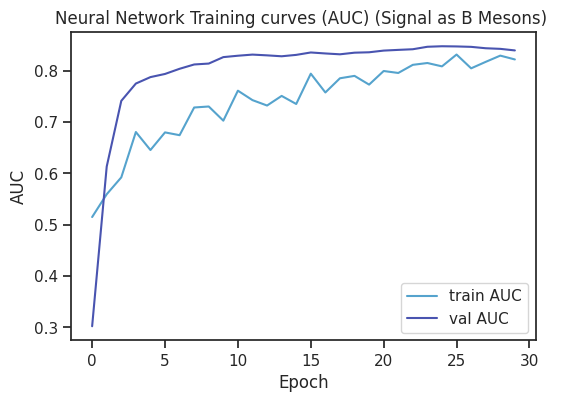

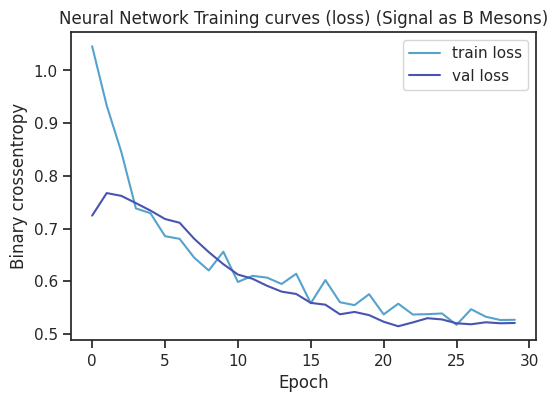

In [508]:
h = history.history
plt.figure(figsize=(6,4))
plt.plot(h['auc'], label='train AUC')
plt.plot(h['val_auc'], label='val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(False)
plt.title('Neural Network Training curves (AUC) (Signal as B Mesons) ')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(h['loss'], label='train loss')
plt.plot(h['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.grid(False)
plt.ylabel('Binary crossentropy')
plt.title('Neural Network Training curves (loss) (Signal as B Mesons)')
plt.legend()
plt.show()


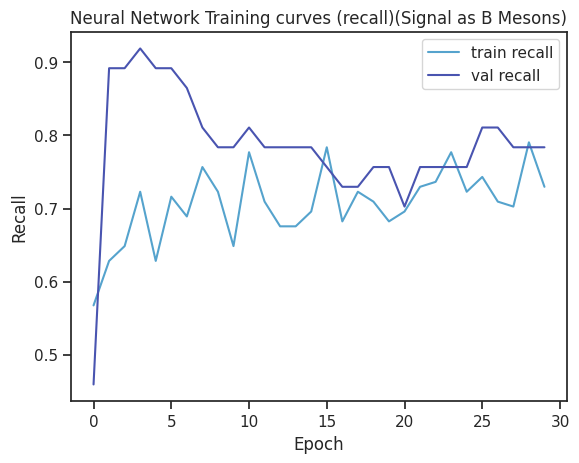

In [509]:
plt.plot(h['recall'], label='train recall')
plt.plot(h['val_recall'], label='val recall')
plt.title("Neural Network Training curves (recall)(Signal as B Mesons)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [510]:
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score, roc_auc_score, confusion_matrix

proba_val_nn = mlp.predict(X_val, batch_size=4096).ravel()
pred_val_nn_05 = (proba_val_nn >= 0.5).astype(int)


metrics_nn = {
    "Accuracy": accuracy_score(y_val, pred_val_nn_05, sample_weight=w_val),
    "F1": f1_score(y_val, pred_val_nn_05, sample_weight=w_val),
    "ROC_AUC": roc_auc_score(y_val, proba_val_nn, sample_weight=w_val),
    "ConfusionMatrix": confusion_matrix(y_val, pred_val_nn_05, sample_weight=w_val)#
}
metrics_nn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


{'Accuracy': 0.7675933125972006,
 'F1': 0.765012285012287,
 'ROC_AUC': np.float64(0.8477267354818371),
 'ConfusionMatrix': array([[815.40647482, 232.10071942],
        [254.7       , 792.4       ]])}

/tmp/ipython-input-2847582700.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)


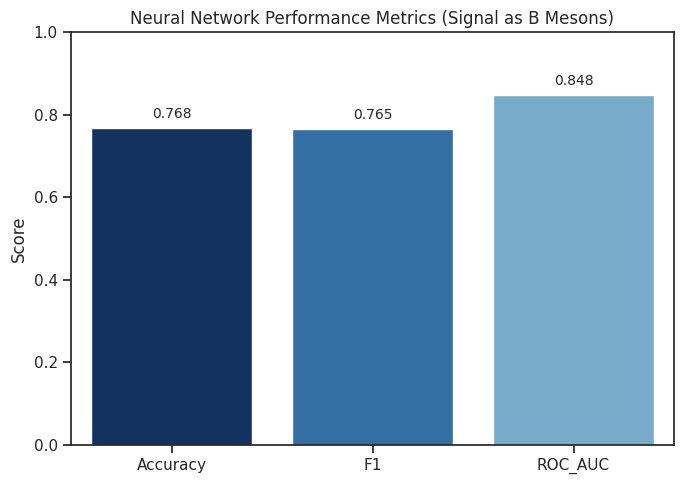

In [513]:
scalar_metrics = {k: v for k, v in metrics_nn.items() if k != "ConfusionMatrix"}
metrics_names = list(scalar_metrics.keys())
metrics_values = list(scalar_metrics.values())

palette = ["#08306b", "#2171b5", "#6baed6"]

plt.figure(figsize=(7,5))
bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)

for bar, value in zip(bars.patches, metrics_values):
    height = bar.get_height()
    bars.annotate(f"{value:.3f}",
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=10)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Neural Network Performance Metrics (Signal as B Mesons)")
plt.tight_layout()
plt.show()


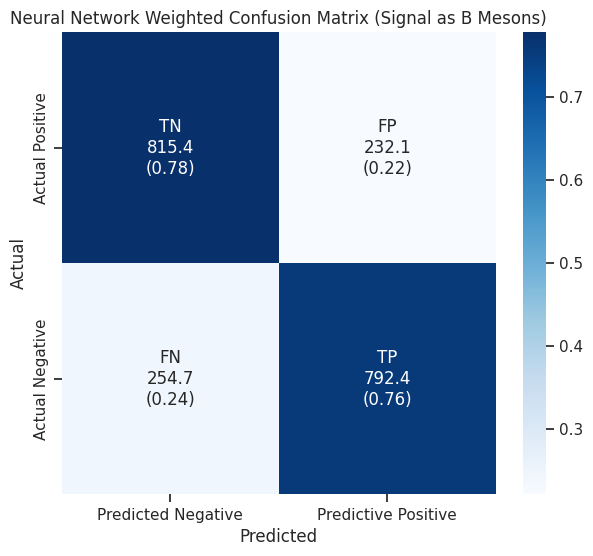

In [514]:
cm = metrics_nn["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Blues",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Weighted Confusion Matrix (Signal as B Mesons)")
plt.show()

0.47302034


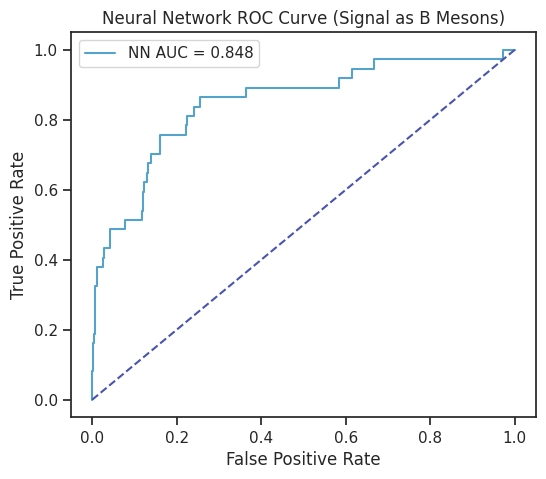

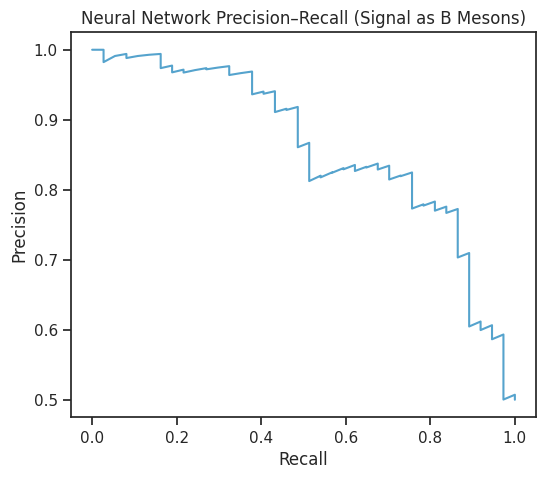

Weighted confusion matrix (threshold=0.5):
 [[815.40647482 232.10071942]
 [254.7        792.4       ]]


In [515]:
# ROC
fpr, tpr, thresholds = roc_curve(y_val, proba_val_nn, sample_weight=w_val)
J = tpr - fpr
best_thresh = thresholds[np.argmax(J)]

print(best_thresh)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"NN AUC = {roc_auc_score(y_val, proba_val_nn, sample_weight=w_val):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve (Signal as B Mesons)");
plt.legend();
plt.show()

# PR
prec, rec, thr = precision_recall_curve(y_val, proba_val_nn, sample_weight=w_val)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.title("Neural Network Precision–Recall (Signal as B Mesons)");
plt.show()

print("Weighted confusion matrix (threshold=0.5):\n", metrics_nn["ConfusionMatrix"])


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━

/tmp/ipython-input-1927350557.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Feature', y='Importance', palette='crest')


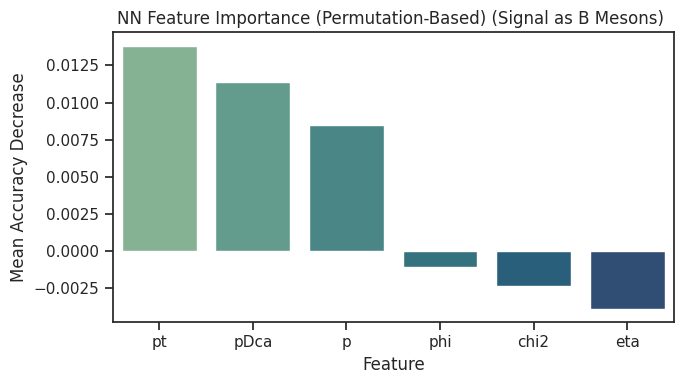

In [516]:
import numpy as np
from sklearn.inspection import permutation_importance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class MLPClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Dummy fit -> (model already trained)
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        proba = proba.ravel()
        return (proba > 0.5).astype(int)

# Wrap trained model
mlp_wrapped = MLPClassifierWrapper(mlp)

# Compute permutation importance
result = permutation_importance(mlp_wrapped, X_val, y_val, scoring='accuracy')

importance_df = pd.DataFrame({
    'Feature': ['eta', 'pt', 'p', 'phi', 'pDca', 'chi2'],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(7,4))
sns.barplot(data=importance_df, x='Feature', y='Importance', palette='crest')
plt.title('NN Feature Importance (Permutation-Based) (Signal as B Mesons) ')
plt.ylabel('Mean Accuracy Decrease')
plt.tight_layout()
plt.show()



In [517]:
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score, roc_auc_score, confusion_matrix

proba_val_nnTest = mlp.predict(X_test, batch_size=4096).ravel()
pred_val_nn_05Test = (proba_val_nnTest >= 0.5).astype(int)


metrics_nnTest = {
    "Accuracy": accuracy_score(y_test, pred_val_nn_05Test),
    "F1": f1_score(y_test, pred_val_nn_05Test),
    "ROC_AUC": roc_auc_score(y_test, proba_val_nnTest),
    "ConfusionMatrix": confusion_matrix(y_test, pred_val_nn_05Test)#
}
metrics_nnTest


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


{'Accuracy': 0.788933675338952,
 'F1': 0.102803738317757,
 'ROC_AUC': np.float64(0.8182037932316847),
 'ConfusionMatrix': array([[2120,  569],
        [   7,   33]])}

/tmp/ipython-input-3547755454.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)


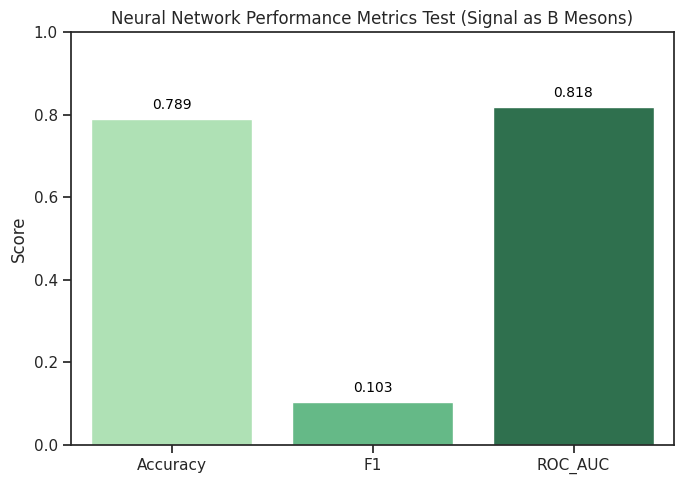

In [518]:
scalar_metricsTest = {k: v for k, v in metrics_nnTest.items() if k != "ConfusionMatrix"}
metrics_namesTest = list(scalar_metricsTest.keys())
metrics_valuesTest = list(scalar_metricsTest.values())

green_palette = ["#A7E9AF", "#57C785", "#247B4D"]

plt.figure(figsize=(7,5))
barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)

for bar, value in zip(barsTest.patches, metrics_valuesTest):
    height = bar.get_height()
    barsTest.annotate(f"{value:.3f}",
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 5),
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=10, color='black')

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Neural Network Performance Metrics Test (Signal as B Mesons)")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Neural Network Unweighted Confusion Matrix Test (Signal as B Mesons)')

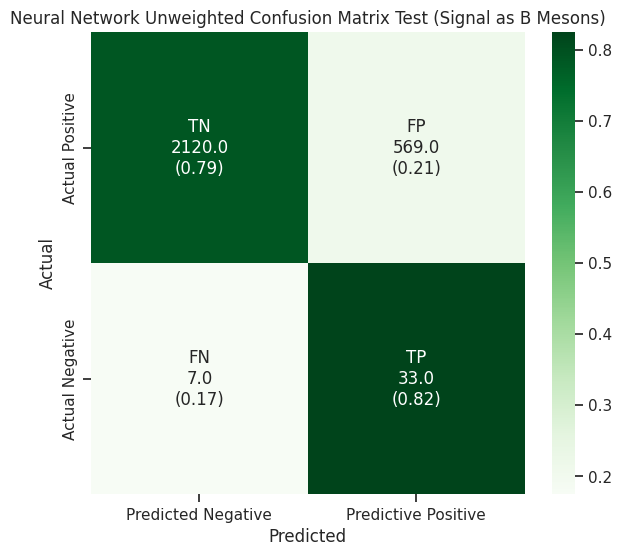

In [519]:
cm = metrics_nnTest["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Greens",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Unweighted Confusion Matrix Test (Signal as B Mesons)")


0.5143988


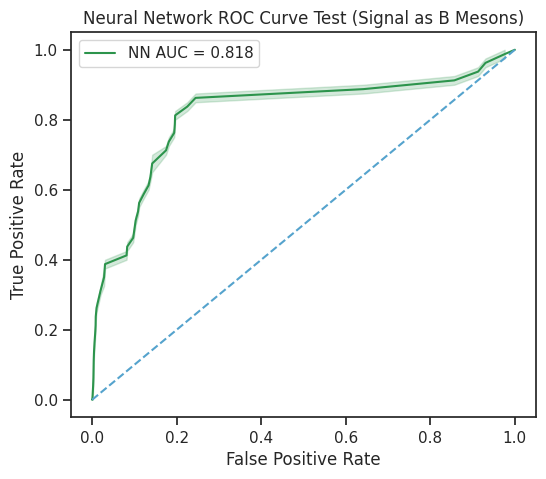

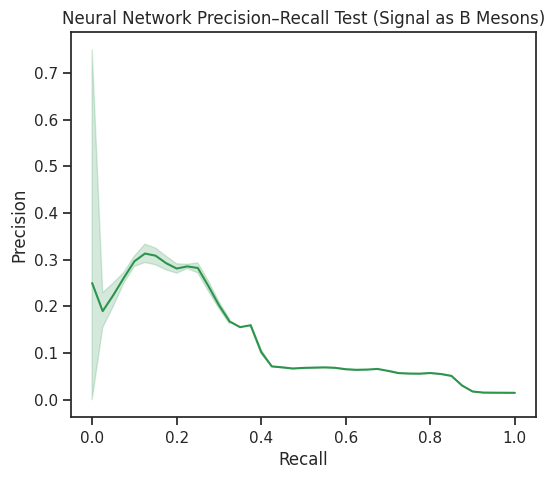

Weighted confusion matrix (threshold=0.5):
 [[815.40647482 232.10071942]
 [254.7        792.4       ]]


In [520]:
# ROC
fprTest, tprTest, thresholds = roc_curve(y_test, proba_val_nnTest)
J = tpr - fpr
best_thresh = thresholds[np.argmax(J)]

print(best_thresh)
plt.figure(figsize=(6,5))
sns.lineplot(x=fprTest, y=tprTest,color = sns.color_palette("Greens")[4],  label=f"NN AUC = {roc_auc_score(y_test, proba_val_nnTest):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve Test (Signal as B Mesons)");
plt.legend();
plt.show()

# PR
precTest, recTest, thr = precision_recall_curve(y_test, proba_val_nnTest)
plt.figure(figsize=(6,5))
sns.lineplot(x=recTest, y=precTest,color = sns.color_palette("Greens")[4])
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.title("Neural Network Precision–Recall Test (Signal as B Mesons)");
plt.show()

print("Weighted confusion matrix (threshold=0.5):\n", metrics_nn["ConfusionMatrix"])

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


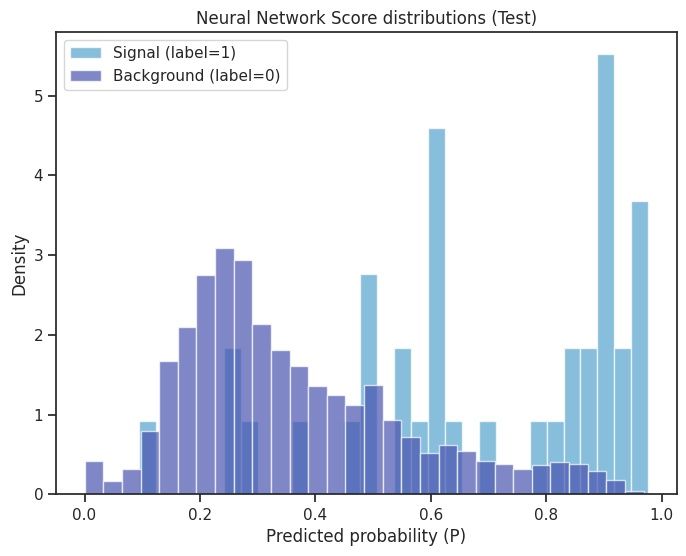

In [521]:
import numpy as np
import matplotlib.pyplot as plt

#predicted probabilities from trained model:
y_pred_prob = mlp.predict(X_val)

signal_scores = y_pred_prob[y_val == 1]
background_scores = y_pred_prob[y_val == 0]

plt.figure(figsize=(8,6))
plt.hist(signal_scores, bins=30, density=True, alpha=0.7, label='Signal (label=1)')
plt.hist(background_scores, bins=30, density=True, alpha=0.7, label='Background (label=0)')

plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Neural Network Score distributions (Test)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.show()

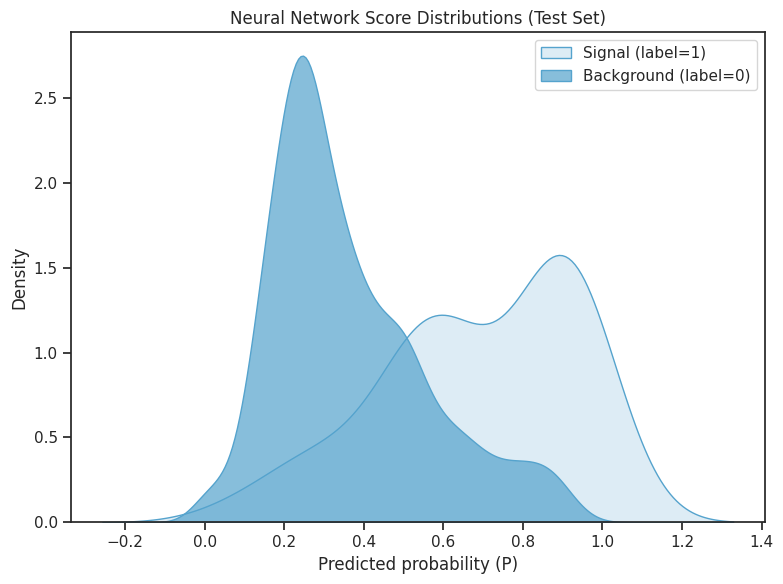

In [522]:
# Smooth KDE plot
colors = sns.color_palette('Blues_r', 2)
plt.figure(figsize=(8,6))
sns.kdeplot(signal_scores, color=colors[0],label='Signal (label=1)', fill=True, alpha=0.2)
sns.kdeplot(background_scores, color=colors[1], label='Background (label=0)', fill=True, alpha=0.7)
plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Neural Network Score Distributions (Test Set)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [481]:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# xgbClassifier = xgb.XGBClassifier(random_state = 42)

# xgbClassifier.fit(X_train, y_train, sample_weight=w_train)


# y_pred = xgbClassifier.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(" Validation Accuracy:", accuracy)

# print("Confusion Matrix:")
# print(confusion_matrix(y_val, y_pred))

# print("Classification Report:")
# print(classification_report(y_val, y_pred))


In [482]:
# from sklearn.model_selection import RandomizedSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'sub_sample': [0.7, 0.85, 1.0],
#     'colsample_bytree': [0.7, 0.85, 1.0],
#     'reg_alpha': [0, 0.01, 0.1,1,10,100],
#     'reg_lambda': [0.5, 0.7, 1.3]
# }

# xgb_model = xgb.XGBClassifier(random_state=42)

# #ten fold cross valid - traiined on 9/10 and validated on 10th
# #gridsearch cv vs randomised search cv

# grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=10, scoring= 'accuracy',n_iter = 10, n_jobs = 1, verbose = 2)

# grid_search.fit(X_train, y_train)

# best_xgb = grid_search.best_estimator_

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)



In [483]:
# y_predTest = best_xgb.predict(X_test)

# test_accuracy = accuracy_score(y_test, y_predTest)
# print("Test Accuracy:", test_accuracy)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_predTest))

# print("Classification Report:")
# print(classification_report(y_test, y_predTest))



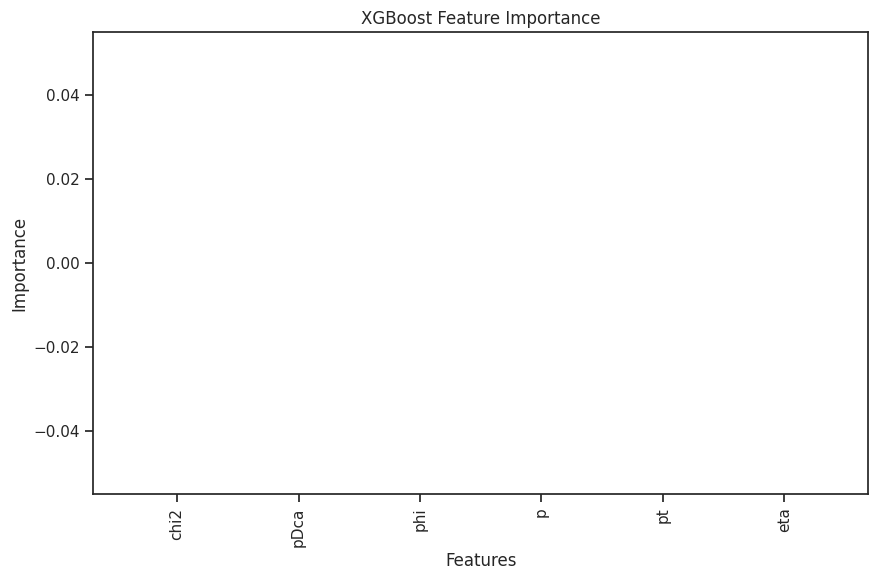

In [484]:
# feature_importances = best_xgb.feature_importances_
# feature_names = X_train_raw.columns

# sorted_indices = np.argsort(feature_importances)[::-1]

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
# plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('XGBoost Feature Importance')
# plt.show()

In [485]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import (
#     confusion_matrix, roc_curve, auc,
#     precision_recall_curve, classification_report, accuracy_score
# )

# # Predict on test set
# y_predTest = best_xgb.predict(X_test)
# y_proba = best_xgb.predict_proba(X_test)[:, 1]

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_predTest)
# cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]
# labels = np.array([["TN", "FP"], ["FN", "TP"]])
# annot = np.empty_like(cm).astype(str)
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"

# plt.figure(figsize=(7,6))
# sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Blues",
#             xticklabels=['Predicted Negative','Predicted Positive'],
#             yticklabels=['Actual Negative','Actual Positive'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("XGBoost Confusion Matrix")
# plt.tight_layout()
# plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# sns.lineplot(x=fpr, y=tpr,  lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.show()

# # Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_test, y_proba)

# plt.figure()
# sns.lineplot(x=recall,y= precision,  lw=2)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.tight_layout()
# plt.show()

# report = classification_report(y_test, y_predTest, output_dict=True)
# metrics = ['precision', 'recall', 'f1-score']
# classes = [key for key in report.keys() if key.isdigit()]

# for metric in metrics:
#     values = [report[cls][metric] for cls in classes]
#     plt.figure()
#     bars = plt.bar(classes, values, color='skyblue')
#     plt.ylim(0, 1.1)
#     plt.title(f'{metric.capitalize()} per Class')
#     plt.ylabel(metric.capitalize())

#     # Add value labels above each bar
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

#     plt.tight_layout()
#     plt.show()